In [1]:
import glob
import os
import sys
import numpy as np
import matplotlib
from scipy.fftpack import fft
from scipy.fft import fft, rfft
from scipy.io import wavfile 
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from scipy.stats import multivariate_normal
import librosa
import librosa.display
from sklearn.cluster import KMeans


import math
from glob import glob


In [2]:

shift_time=10   #10ms
window_time=25    #25ms
music_sr=[]



In [3]:
# Read the data from the .wav files
def read_data(dir):
     
    audio_files = glob(dir+'/*.wav')
    samplerate, data = wavfile.read(audio_files[0])
    sh=int(samplerate*shift_time*0.001)
    No_of_shift = len(range(0,len(data),sh))
    window_length=int(samplerate*window_time*0.001)
     # This will have data of all the files which are given in the dir
    final_data=np.zeros((len(audio_files),No_of_shift-3,window_length))     
    for file in range(len(audio_files)):
        
        samplerate, data = wavfile.read(audio_files[file])
        window_length=int(samplerate*window_time*0.001)
        sh=int(samplerate*shift_time*0.001)  #160
        No_of_shift = len(range(0,len(data),sh))
        hamming_output=np.hamming(window_length)
        j=0
        for i in range(No_of_shift-3):
            if(len(data[j:])>=window_length):
                final_data[file][i][:]=(data[j:j+window_length] *hamming_output)
            else:
                break
            j=j+sh
    return final_data                  # return the final data

In [4]:
# Take the data convert into spectrogram
def specto(mag_fft,final_data):
    audio_files = glob(data_dir+'/*.wav')
    fft_data=np.zeros([len(audio_files)*(No_of_shift-3),32])
    k=0
    for file in range(0, len(audio_files),1):
        
        fft=np.log(np.absolute(np.fft.fft(final_data[file],mag_fft)))
        newfft=np.zeros([No_of_shift-3,32])
        newfft=fft[:,0:32]
#         fft=np.log(np.absolute(np.fft.rfft(final_data[file],mag_fft)))
#         newfft=fft[:,0:32]
        for i in range(No_of_shift-3):
            fft_data[k,:]=newfft[i,:]
            k=k+1
    return fft_data

In [5]:
#plotting the spectrogram
def plot_spec(data):
    plt.figure(figsize=(24,14))
    plt.imshow((data.T))
    plt.show()

In [6]:
#Returning a covariance matrix
def cov_mat(fft_data):
    print(len(fft_data))
    cov_mat=np.matmul(fft_data.T,fft_data)
    cov_mat=cov_mat/len(fft_data-1)
    return cov_mat

In [7]:
data_dir = 'speechMusicData/speech_music_classification/train/music'
audio_files = glob(data_dir+'/*.wav')                #get the data of all the music files
samplerate, data = wavfile.read(audio_files[0])
sh=int(samplerate*shift_time*0.001)
No_of_shift = len(range(0,len(data),sh))
window_length=int(samplerate*window_time*0.001)


In [8]:
music_data=read_data(data_dir)                #[40][2997][400]
data_dir = 'speechMusicData/speech_music_classification/train/speech'   #get the data of all the speech files
speech_data=read_data(data_dir)
print(np.shape(music_data))

(40, 2997, 400)


In [9]:
mag_fft=64
# 64 component magnitude FFT of music and take the 32 dimensions of it
fft_music=specto(mag_fft,music_data)           
fft_speech=specto(mag_fft,speech_data)
print(np.shape(fft_music))
print(np.shape(fft_speech))
# combine both the music and speech data
fft_data=np.concatenate((fft_music, fft_speech), axis=0)
np.shape(fft_data)

(119880, 32)
(119880, 32)


(239760, 32)

In [10]:
def Kmeans(fft_data):
    kmean=KMeans(n_clusters=8,max_iter=5)
    kmean.fit(fft_data)
    return kmean
data_mean=Kmeans(fft_data)

Storing all the observation in observ

In [11]:
meanVectors=data_mean.cluster_centers_
data_labeling=data_mean.labels_
data_labeling

array([6, 6, 6, ..., 3, 3, 2])

In [12]:
nof=40
T=2997
observ_music=np.zeros((40,2997),dtype=int)
observ_speech=np.zeros((40,2997),dtype=int)
k=0
for i in range(nof):
    for j in range(T):
        observ_music[i][j]=data_labeling[k]
        k=k+1
        
for i in range(nof):
    for j in range(T):
        observ_speech[i][j]=data_labeling[k]
        k=k+1

In [13]:

T=2997           #Initializing the T
N=3              # Initializing the value of N
   
######################## Initializing the value of pi,A and B ##############
pi=np.array([0.5,0.5,0.0])
A=np.array([[0.6,0.4,0.0],[0.3,0.5,0.2],[0.0,0.1,0.9]])
B=np.array([[0.25, 0.25 ,0.25 ,0.25, 0.0 ,0.0 ,0.0, 0.0],[0.125, 0.125 ,0.125 ,0.125,0.125, 0.125 ,0.125 ,0.125],[0.0 ,0.0, 0.0, 0.0 ,0.0 ,0.5 ,0.5 ,0.0]])


Likelihood computation using the forward variable.

In [14]:
def forward(A,B,pi,observ):
    sum=0
    T=len(observ)
    c=[0]*T
    
    N=A.shape[0]

    ########################Initialization Step ################
    alpha=np.zeros((T,N))
    for i in range(N):
        alpha[0][i]=B[i][observ[0]]*pi[i]
        sum=sum+alpha[0][i]
    c[0]=1/sum
    
    for i in range(N):
        alpha[0][i]*=c[0]
        
    for t in range(1,T):
        sum=0
        for j in range(N):
            alpha[t][j]=0
            for i in range(N):
                alpha[t][j]+=(alpha[t-1][i]*A[i][j])
            alpha[t][j]*=B[j][observ[t]]
            sum+=alpha[t][j]
        c[t]=1/sum
        #print(sum)
        for i in range(N):
            alpha[t][i]*=c[t]
    sum=0
    for i in range(T):
        sum+=np.log(c[i])
    sum=-sum
    sum
    return alpha,sum,c

likelihood computation using the backward variable

In [15]:
def backward(A,B,pi,observ,c):
    sum=0
    T=len(observ)
   
    N=A.shape[0]
    Beta=np.zeros((T,N))
    sum=0
    
    ### Intialization ##########
    for i in range(N):
        Beta[T-1][i]=1   
    for i in range(N):
        Beta[T-1][i]*=c[T-1]
        
        
    for t in range(T-2,-1,-1):
        
        for i in range(N):
            for j in range(N):
                Beta[t][i]+=(Beta[t+1][j]*A[i][j]*B[j][observ[t+1]])
            Beta[t][i]*=c[t]
    sum=0
    for i in range(T):
        sum+=np.log(c[i])
    sum=-sum
    return Beta,sum

Viterbi algorithm to decode the
best state sequence

In [16]:
def viterbi(A,B,pi,observ):
    T=len(observ)
    N=len(A)
    Q=[1]*T
    Delta=np.ones((T,N))
    
    tiny=1
    log_A=np.log(tiny+A)
    log_pi=np.log(tiny+pi)
    log_B=np.log(tiny+B)
    back=np.ones((T,N))
    #Initialize

    for i in range(N):
        Delta[0][i]=log_B[i][observ[0]]+log_pi[i]
        back[0][i]=0


    for t in range(1,T):
        for j in range(N):
            max_i=float('-inf')

            for i in range(N):
                if (Delta[t-1][i] + log_A[i][j]) > max_i:
                    back[t][j]=i
                    max_i=Delta[t-1][i] + log_A[i][j]
                    

            Delta[t][j]=max_i + log_B[j][observ[t]]   

    #### Termination###########
    max_i=float('-inf')
    for i in range(N):
        if Delta[T-1][i]> max_i:
            Q[T-1]=i
            max_i=Delta[T-1][i]


    for i in range(T-2,-1,-1):
        Q[i]=int(back[i+1][Q[i+1]])
    return Delta,Q

Compute Gamma

In [17]:
def compute_gamma(alpha,Beta):
    T=len(alpha)
    N=len(alpha[0])
    gamma=np.zeros((T,N))
    
    for t in range(T):
        sum=0
        for i in range(N):
            gamma[t][i]=alpha[t][i] * Beta[t][i]
            sum+=gamma[t][i]
        for i in range(N):
            gamma[t][i]/=sum
    return gamma

Compute Zetta

In [18]:
def compute_zetta(A,B,observ,alpha,Beta):                    # Till T or T-1
    T=len(alpha)
    N=len(alpha[0])
    zetta=np.zeros((T-1,N,N))
    for t in range(T-1):
        sum=0
        for i in range(N):
            for j in range(N):
                zetta[t][i][j]=(alpha[t][i]*A[i][j]*B[j][observ[t+1]]*Beta[t+1][j])
                sum+=zetta[t][i][j]
        zetta[t][i][j]/=sum
    return zetta        

compute A

In [19]:
def compute_aij(zetta,gamma, i, j):
    numerator=0.0
    denominator=0.0
    n_ob=len(zetta)
    n_t=len(zetta[0])
    
    for k in range(n_ob):
        for t in range(n_t):
            numerator +=zetta[k][t][i][j]
            denominator+=gamma[k][t][i]
    ans=numerator/denominator
    return ans

In [20]:
def update_A(zetta,gamma):
    
    N=len(gamma[0][0])
    n_A= np.zeros((N,N))
    
        
    for i in range(N):
        for j in range(N):
            n_A[i][j]=compute_aij(zetta,gamma,i,j)
    return n_A

Compute B

In [21]:
def compute_bi(gamma,i,observ,vk):
    numerator=0.0
    denominator=0.0
    n_ob=len(gamma)
    n_t=len(gamma[0])
    s=0
    for k in range(n_ob):
        for t in range(n_t):
            denominator+=gamma[k][t][i]
            if observ[k][t]==vk:
                numerator+=gamma[k][t][i]
                s=s+1
    bi=numerator/denominator
    return bi
    

In [22]:
def compute_B(delta,gamma,symbol,observ):
    N=len(gamma[0][0])
    n_B=np.zeros((N,len(symbol)))
    for i in range(N):
        for vk in symbol:
            n_B[i][vk]=compute_bi(gamma,i,observ,vk)
    return n_B

Compute pi

In [23]:
def compute_pi(gamma):
    N=len(gamma[0][0])
    pi =np.zeros(N)
    for i in range(N):
        for k in range(len(gamma)): 
            pi[i] += gamma[k][0][i] 
    po=np.sum(pi)                 #normalize it
    pi=pi/po
    return pi

Find Likelihood of all the files(either music or speech)

In [24]:
def find_likelihood(A,B,pi,observ):
    sum=0
    for i in range(len(observ)):
        alpha,likeli,c=forward(A,B,pi,observ[i])
        sum+=likeli
    return sum/len(observ)

<br>



            #########################   Part-A ###########################



<br>


In [43]:
from random import randrange
mf=randrange(40)
sf=randrange(40)

In [44]:
ob_music=observ_music[mf]
ob_speech=observ_speech[sf]
alpha,like_music,cm=forward(A,B,pi,ob_music)
alpha,like_speech,cp=forward(A,B,pi,ob_speech)

In [45]:
print("The Likelihoood using forward variable for music file is",like_music)

The Likelihoood using forward variable for music file is -5961.831865752121


In [46]:
print("The Likelihoood using forward variable for speech file is",like_speech)

The Likelihoood using forward variable for speech file is -6487.665273682664


From here I have concluded that most of the times music likelihood is more compare to speech but i observe there are some files for which the speech is also more (for eg-> 39 file of music,39 file of speech) so from this i can say that it depends on which file you have taken for music and speech.

<br>
<br>

                ######################### Part-B ###########################

<br>

Here given by the Procedure in the book(and also the reference shared in teams) that i follow from there written in page 367
"Since each scale factor effectively restores the magnitude
of the alpha terms to 1, and since the magnitudes of the alpha and
beta terms are comparable, using the same scaling factors on
the Beta's as was used on the alpha's is an effective way of keeping
the computation within reasonable bounds". I have used the same procedure written over there and compute Beta which is there in compute_B funtion. And since it is also written that in page 368

"The only real change to the HMM procedure because of
scaling is the procedure for computing likelihood. We cannot
merely sum up the alphaT(i) terms since these are scaled already."

And they used a property written over there and shows that it negative(sum of all ci's)
in equation(6.106) 
Since the procedure written in the book to compute the likelihood for the forward variable computation.
And After scaling it is mentioned that we can not use alphaT so use Ci's for 
likelihood.

In [47]:
Beta,like_backm=backward(A,B,pi,ob_music,cm)
Beta,like_backs=backward(A,B,pi,ob_speech,cp)

In [48]:
print("The Likelihoood using backward variable for music file is",like_backm)

The Likelihoood using backward variable for music file is -5961.831865752121


In [49]:
print("The Likelihoood using backward variable for music file is",like_backs)

The Likelihoood using backward variable for music file is -6487.665273682664


<br>

                ######################### Part-C ###########################

<br>

In [32]:
# find likelihood of all the music(average) and store it in a list
musicprevlikeli=find_likelihood(A,B,pi,observ_music)
listmusiclikeli=[]
listmusiclikeli.append(musicprevlikeli)


In [33]:
# find likelihood of all the speech(average) and store it in a list

speechprevlikeli=find_likelihood(A,B,pi,observ_speech)
listspeechlikeli=[]
listspeechlikeli.append(speechprevlikeli)


In [34]:
#initializing for music A,B and pi and for speech A,B and pi
m_A=A
s_A=A
m_B=B
s_B=B
m_pi=pi
s_pi=pi

In [35]:
# Plotting the likelihoods for a given file
def plotting(li,name):
    plt.xlabel('no of iterations')

    plt.ylabel('Log-likelihood')

    # giving a title to my graph
    plt.title(name)
    plt.plot(li)
    plt.show()

E-M step

In [36]:
############### Baum-Welch reestimation method ###############
def EM(A,B,pi,observ,li):
    
    count=0
    
    while True:
        


        # For training we have to take all the observations of music and for speech also
        # so computing zetta and gamma for all the observaiton useful for
        # updating A, B and pi
        
        zetta=[]
        for i in range(len(observ)):
            alpha,likeli,c=forward(A,B,pi,observ[i])
            Beta,like_back=backward(A,B,pi,observ[i],c)
            z=compute_zetta(A,B,observ[i],alpha,Beta)
            zetta.append(z)

        gamma=[]
        for i in range(len(observ)):
            alpha,likeli,c=forward(A,B,pi,observ[i])
            Beta,like_back=backward(A,B,pi,observ[i],c)
            g=compute_gamma(alpha,Beta)
            gamma.append(g)

        delta=[]
        for i in range(len(observ)):
            d,q=viterbi(A,B,pi,observ[i])
            delta.append(d)

        A=update_A(zetta,gamma)
        symbol=[]
        for i in range(len(B[0])):
            symbol.append(i)
        B=compute_B(delta,gamma,symbol,observ)       #for update B we need symbols

        pi=compute_pi(gamma)


        likeli=find_likelihood(A,B,pi,observ)
        print(likeli)
        if(int(li[-1])==int(likeli)):               #used to check when to convergence here 
            li.append(likeli)
            break
        else:
            li.append(likeli)
        count=count+1
        
    return A,B,pi

Perform the Baum-Welch reestimation
method to train HMMs with all the HMM training examples for speech and for music
(two different HMMs). 
Also printing the likelihood at each iteration from which we can conclude that the likelihood are increasing.

The log-likelihood for music files at iterations are 
-5353.435363052119
-5331.601504068605
-5323.341941394037
-5315.712276769332
-5305.201034092168
-5288.757486811849
-5262.613017776434
-5224.673594874259
-5181.038048489947
-5145.162654738851
-5124.004832278475
-5113.898496879211
-5109.135467721714
-5106.571847244801
-5104.9706866009365
-5103.865005691814
-5103.056279368561


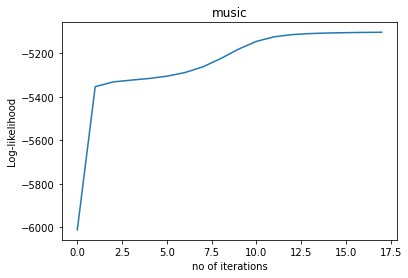

The log-likelihood for speech files at iterations are 
-5668.012850110356
-5618.03736987881
-5555.6850357154535
-5463.343265596986
-5326.114677045579
-5196.072925812736
-5144.522882873095
-5125.44171137084
-5111.598141022164
-5099.7683581938445
-5090.977362712218
-5085.472496179279
-5082.328497325221
-5080.5241350256165
-5079.420351650822
-5078.686679114153
-5078.15743978659


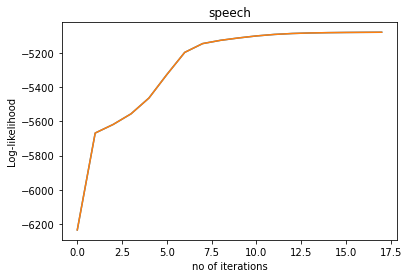

In [37]:
print("The log-likelihood for music files at iterations are ")
m_A,m_B,m_pi=EM(m_A,m_B,m_pi,observ_music,listmusiclikeli)

plotting(listmusiclikeli,"music")


print("The log-likelihood for speech files at iterations are ")

s_A,s_B,s_pi=EM(s_A,s_B,s_pi,observ_speech,listspeechlikeli)
plt.plot(listspeechlikeli)
plotting(listspeechlikeli,"speech")
plt.show()

In [38]:
# Take a single observation file and making the array
def specto_test(mag_fft,final_data):
    fft_data=np.zeros([(No_of_shift-3),32]) 
    fft=np.log(np.absolute(np.fft.fft(final_data,mag_fft)))
    fft_data=fft[:,0:32]
    
    return fft_data

Code for Test-Data

In [39]:
###############################   Testing #################################
def Testing(mu_A,mu_B,mu_pi,sp_A,sp_B,sp_pi):
    audio = 'speechMusicData/speech_music_classification/test'
    test_data=read_data(audio)
    count=0
    for i in range(len(test_data)):
            # Taking the spectrogram for the given data set.
            fft_test=specto_test(mag_fft,test_data[i])            
            ob=data_mean.predict(fft_test)
            malpha,mlikeli,mc=forward(mu_A,mu_B,mu_pi,ob)  
            salpha,slikeli,sc=forward(sp_A,sp_B,sp_pi,ob)

            if(mlikeli>slikeli):
                print("music")
                if(i<=23):
                    count=count+1

            else:
                print("speech")
                if(i>=24):
                    
                    count=count+1
    return count

In [40]:
correct=Testing(m_A,m_B,m_pi,s_A,s_B,s_pi)

music
music
music
music
music
music
music
music
music
music
music
music
music
music
music
music
music
speech
music
music
music
music
speech
music
speech
speech
speech
speech
music
speech
speech
speech
music
speech
speech
music
music
speech
speech
speech
speech
speech
music
speech
speech
speech
speech
speech


In [41]:
print("The Accuracy is",(correct/48)*100,"%")

The Accuracy is 85.41666666666666 %


Report of the Performance-> The Accuracy in most of the cases which i get is from 79% to 85% since i have KMeans with random intialization, so accuracy might vary and since they are very less test points.